In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math


In [7]:
# Time Steps and Total Time for the simulation
total_time = 30  # Total time of simulation (in arbitrary units)
time_steps = 1000  # Number of time steps to simulate over
time_increment = total_time / time_steps  # Time increment per step

# Ensure that the number of time steps is a positive integer
assert time_steps > 0, "time_steps must be a positive integer"

# Number of Nuclei and Total Number of Nuclear Spin States
nuclei_number = 1  # Number of nuclei in the system
total_spin_number = nuclei_number + 1  # Total spin number includes electron and nuclei
Zi = 2**nuclei_number  # Partition function for the nuclear spins (assuming spin-1/2 particles)

# Ensure that the number of nuclei is valid
assert nuclei_number > 0, "nuclei_number must be a positive integer"

# Hyperfine Coupling Constants (a_ik), these define the interaction between nuclear spins and the electron spin
a_ik = [-0.999985, -0.7369246, 0.511210, -0.0826998, 0.0655341, -0.562082, 
        -0.905911, 0.357729, 0.358593, 0.869386, -0.232996, 0.0388327, 
        0.661931, -0.930856, -0.893077, -0.0594001]

# Ensure the number of hyperfine constants matches the expected number of nuclei
assert len(a_ik) >= nuclei_number, "Insufficient hyperfine coupling constants for the number of nuclei"

# Symplectic Integrator Constants
# These coefficients are used for time evolution via symplectic integrators
# a_coefficients and b_coefficients come from symplectic integration methods (e.g., Suzuki-Trotter decompositions)
b_coefficients = np.array([0.1118965355841512, 0.7035015731785551, -0.1465431690690314, 0.3311450603063251])
a_coefficients = np.array([0.3311450603063251, -0.1465431690690314, 0.7035015731785551, 0.1118965355841512])

# Ensure that the symplectic coefficients arrays have the expected length
assert len(a_coefficients) == len(b_coefficients), "Symplectic integrator coefficients must have the same length"

# Magnetic Field Strength (in arbitrary units)
Mag_str = 0.5  # Strength of the applied magnetic field

# Gyromagnetic Ratio (of the electron in atomic units)
gyro_ratio = -1.001  # Gyromagnetic ratio for the electron spin

# Larmor frequency (Wi) for the electron in the magnetic field
wi = -gyro_ratio * Mag_str  # Larmor frequency related to the magnetic field and gyromagnetic ratio

# Define Spin Operators (Pauli matrices scaled by 1/2 to represent spin-1/2 systems)

# Electron spin operators (Sx, Sy, Sz)
Sx = 0.5 * np.array([[0, 1], [1, 0]])  # Spin-x operator for the electron
Sy = 0.5 * np.array([[0, -1j], [1j, 0]])  # Spin-y operator for the electron
Sz = 0.5 * np.array([[1, 0], [0, -1]])  # Spin-z operator for the electron

# Nuclear spin operators (Ikx, Iky, Ikz)
# Assuming the nuclei have spin-1/2, the operators are identical to the electron spin operators
Ikx = 0.5 * np.array([[0, 1], [1, 0]])  # Spin-x operator for the nucleus
Iky = 0.5 * np.array([[0, -1j], [1j, 0]])  # Spin-y operator for the nucleus
Ikz = 0.5 * np.array([[1, 0], [0, -1]])  # Spin-z operator for the nucleus





In [8]:
def tensor_product_operator(spin_position, spin_operator):
    """
    Construct the tensor product of spin operators for a given position.

    Parameters:
    spin_position (int): Position of the spin where the operator is applied.
    spin_operator (np.array): The spin operator matrix (e.g., Sx, Sy, Sz, Ikx, Iky, Ikz).

    Returns:
    np.array: Tensor product of identity matrices and the applied spin operator.
    """
   
    spin_array = [np.identity(2) for _ in range(nuclei_number)]
    
    
    spin_array[spin_position] = spin_operator

    
    S = spin_array[0]
    for i in range(1, nuclei_number):
        S = np.kron(S, spin_array[i])
    
    return S


def Hamiltonian():
    """
    Constructs the Hamiltonian matrix for the system.
    
    Returns:
    np.array: Hamiltonian matrix combining the Zeeman and hyperfine interactions.
    """
    # Initialize the hyperfine interaction matrix as a zero matrix
    Hyperfine_interaction = np.zeros((2**total_spin_number, 2**total_spin_number), dtype=complex)

    # Precompute spin operators for each nucleus
    Ikx_array = [None] * nuclei_number
    Iky_array = [None] * nuclei_number
    Ikz_array = [None] * nuclei_number

    
    for i in range(nuclei_number):
        Ikx_array[i] = tensor_product_operator(i, Ikx)
        Iky_array[i] = tensor_product_operator(i, Iky)
        Ikz_array[i] = tensor_product_operator(i, Ikz)

    
    Zeeman_interaction = wi * (np.kron(Ikz_array[0], np.identity(2)))

    
    for i in range(nuclei_number):
        Hyperfine_interaction += a_ik[i] * (
            np.kron(Sx, Ikx_array[i]) + 
            np.kron(Sy, Iky_array[i]) + 
            np.kron(Sz, Ikz_array[i])
        )
    
    # The total Hamiltonian is the sum of Zeeman and hyperfine interactions
    return Zeeman_interaction + Hyperfine_interaction


def get_sigma_m(s_pins, n_spin):
    """
    Translates a nuclei spin arrangement into a vector of tensor products.
    
    Parameters:
    s_pins (str): Spin state of the electron ('up' or 'down').
    n_spin (tuple): Spin states of the nuclei (tuple of 'up' or 'down').
    
    Returns:
    np.array: The tensor product state vector corresponding to the spin arrangement.
    """
    combined_spins = (s_pins,) + n_spin  
    vector_array = [None] * len(combined_spins)

    # Map 'up' to [1, 0] and 'down' to [0, 1] for each spin
    for i in range(total_spin_number):
        if combined_spins[i] == 'up':
            vector_array[i] = [1, 0]
        elif combined_spins[i] == 'down':
            vector_array[i] = [0, 1]
        else:
            raise ValueError("Invalid spin state: must be 'up' or 'down'")

    
    tensor_product = vector_array[0]
    for j in range(1, len(vector_array)):
        tensor_product = np.kron(tensor_product, vector_array[j])

    return tensor_product


def possible_nuclei_spins():
    """
    Generates all possible nuclear spin configurations.
    
    Returns:
    list of tuples: List of all possible spin configurations ('up', 'down') for the nuclei.
    """
    nuclei_spins = list(itertools.product(range(2), repeat=nuclei_number))
    mapped_spins = [tuple('up' if spin == 0 else 'down' for spin in arrangement) for arrangement in nuclei_spins]
    return mapped_spins


def calculate_energy(psi_t, Hi):
    """
    Calculate the energy of the system at a given time step.
    
    Parameters:
    psi_t (np.array): State vector at time t.
    Hi (np.array): Hamiltonian matrix.
    
    Returns:
    float: Energy of the system at time t.
    """
    psi_t_conj = np.conjugate(psi_t)  
    H_psi_t = np.matmul(Hi, psi_t)  
    energy = np.dot(psi_t_conj, H_psi_t)  
    return energy


def Sympletic_integrator(q_t, p_t, Hi):
    """
    Perform a symplectic integration step for time evolution.
    
    Parameters:
    q_t (np.array): Position (real part of the state vector) at time t.
    p_t (np.array): Momentum (imaginary part of the state vector) at time t.
    Hi (np.array): Hamiltonian matrix.
    
    Returns:
    np.array, np.array: Updated position and momentum after time evolution.
    """
    p_list = {'p_0': p_t}
    q_list = {'q_0': q_t}
    
    
    for j in range(4):
        p_list['p_' + str(j+1)] = p_list['p_' + str(j)] - (b_coefficients[j] * time_increment * np.dot(Hi, q_list['q_' + str(j)]))
        q_list['q_' + str(j+1)] = q_list['q_' + str(j)] + (a_coefficients[j] * time_increment * np.dot(Hi, p_list['p_' + str(j+1)]))

    return q_list['q_4'], p_list['p_4']


def Psi_t(q0, p0, Hi):
    """
    Calculate the time evolution of the system using symplectic integration.
    
    Parameters:
    q0 (np.array): Initial real part of the state vector.
    p0 (np.array): Initial imaginary part of the state vector.
    Hi (np.array): Hamiltonian matrix.
    
    Returns:
    list of np.array: Time evolution of the wave function psi(t).
    """
    psi_t = [0] * time_steps  
    psi_t[0] = q0 + 1j * p0  

    q_t = q0
    p_t = p0

    
    for i in range(1, time_steps):
        q_t, p_t = Sympletic_integrator(q_t, p_t, Hi)
        psi_t[i] = q_t + (1j * p_t)

    return psi_t


def exp_coeff(spins1, spins2, nspin1, nspin2, Hi):
    """
    Calculate the expansion coefficient for a pair of spin states over time.
    
    Parameters:
    spins1 (str): Electron spin state for the first configuration ('up' or 'down').
    spins2 (str): Electron spin state for the second configuration ('up' or 'down').
    nspin1 (tuple): Nuclear spin configuration for the first state.
    nspin2 (tuple): Nuclear spin configuration for the second state.
    Hi (np.array): Hamiltonian matrix.
    
    Returns:
    np.array: Expansion coefficient over time.
    """
    sigma_m_1 = get_sigma_m(spins1, nspin1)
    sigma_m_2 = get_sigma_m(spins2, nspin2)

    p0 = np.zeros_like(sigma_m_1)
    psi_t = Psi_t(sigma_m_1, p0, Hi)
    
    expansion_coefficient = np.zeros(time_steps, dtype=complex)

    
    for i in range(time_steps):
        expansion_coefficient[i] = np.dot(sigma_m_2, psi_t[i])

    return expansion_coefficient


def Calculate_R_xx_Rxy_R_zz():
    """
    Calculate the relaxation rates R_xx, R_xy, and R_zz over time.
    
    Returns:
    np.array, np.array, np.array: R_xx, R_xy, and R_zz relaxation rates over time.
    """
    Hi = Hamiltonian()
    prefactor_R_xx_R_xy = 1 / (2 * Zi)
    prefactor_R_zz = 1 / (4 * Zi)
    
    nuclei_spins = possible_nuclei_spins()
    
    exp_coeff_sum_R_xx_R_xy = np.zeros(time_steps, dtype=complex)
    exp_coeff_sum_R_zz = np.zeros(time_steps, dtype=complex)

    
    for nspin1 in nuclei_spins:  # M
        for nspin2 in nuclei_spins:  # M'
            exp_coeff_up_up = exp_coeff('up', 'up', nspin1, nspin2, Hi)
            exp_coeff_down_down = exp_coeff('down', 'down', nspin1, nspin2, Hi)
            exp_coeff_down_up = exp_coeff('down', 'up', nspin1, nspin2, Hi)
            exp_coeff_up_down = exp_coeff('up', 'down', nspin1, nspin2, Hi)
            
            
            for i in range(time_steps):
                
                exp_coeff_sum_R_xx_R_xy[i] += (
                    np.conjugate(exp_coeff_up_up[i]) * exp_coeff_down_down[i] +
                    np.conjugate(exp_coeff_up_down[i]) * exp_coeff_down_up[i]
                )
                
                
                exp_coeff_sum_R_zz[i] += (
                    np.conjugate(exp_coeff_up_up[i]) * exp_coeff_up_up[i] -
                    np.conjugate(exp_coeff_up_down[i]) * exp_coeff_up_down[i] -
                    np.conjugate(exp_coeff_down_up[i]) * exp_coeff_down_up[i] +
                    np.conjugate(exp_coeff_down_down[i]) * exp_coeff_down_down[i]
                )
    
   
    R_xx_iR_xy = prefactor_R_xx_R_xy * exp_coeff_sum_R_xx_R_xy
    R_xx = np.real(R_xx_iR_xy)
    R_xy = np.imag(R_xx_iR_xy)  
    R_zz = np.real(prefactor_R_zz * exp_coeff_sum_R_zz)
    
    return R_xx, R_xy, R_zz




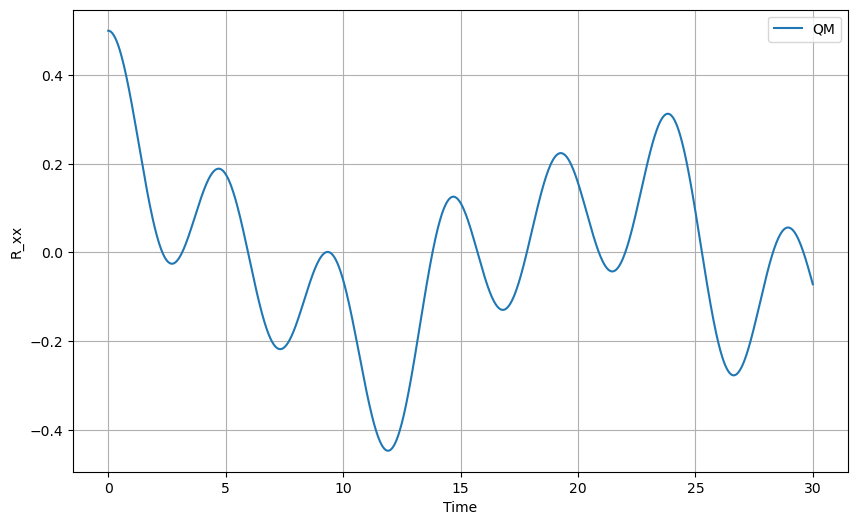

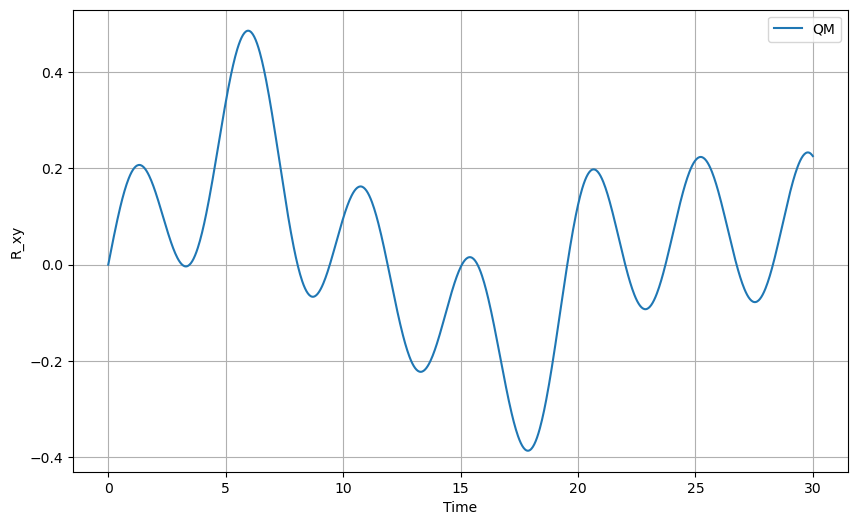

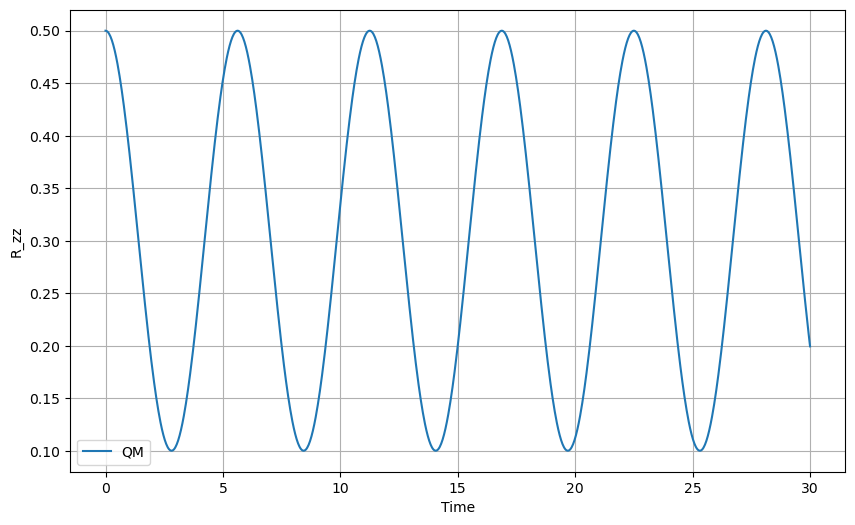